In [8]:
import numpy as np
from forecast_wrapper import forecast_model
import matplotlib.pyplot as plt

def _mixture_mean_std(means: np.ndarray, sds: np.ndarray, weights: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Return the mixture mean and standard deviation for each step."""
    mean = means @ weights
    var = (sds**2 + means**2) @ weights - mean**2
    return mean, np.sqrt(var)

# 1) ── Generate a simple synthetic series ────────────────────────────────────
#    y(t) = sin(2πt / 20)  + gaussian noise
np.random.seed(42)
t = np.arange(160)
y = np.sin(2 * np.pi * t / 20) + 0.3 * np.random.randn(len(t))

# Split 140 points for training, keep the last 20 for visual sanity checks
y_train, y_test = y[:140], y[140:]

In [3]:
# 2) ── LSTM forecast (recursive) ─────────────────────────────────────────────
lstm_res = forecast_model(
    model="LSTM",
    y_train=y_train,
    steps=5,
    lag=30,           # use 30-point windows
    epochs=40,
    verbose=0,
    n_components=2,
)

/opt/conda/envs/ts-forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
arima_res = forecast_model(
    model="ARIMA",
    y_train=y_train,
    steps=5,
    frequency=1,      # not strictly needed here (no seasonality)
    n_components=2,
    # order=(2,1,2),  # uncomment to pin (p,d,q) instead of auto search
)

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [5]:
# 3b) ── HMM forecast (hmmTMB via rpy2) ───────────────────────────────────────
hmm_res = forecast_model(
    model="HMM",
    y_train=y_train,
    steps=5,
    n_states=2,
    hid_formula=None
)

R[write to console]: code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit4model_tmb” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

R[write to console]: code for methods in class “Rcpp_stan_fit4model_tmb” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)



$y
[1] "norm"



In [9]:
print("Target (next 5 actual points):")
print(y_test[:5])
print("\nLSTM  forecast mixture means:")
print(lstm_res["forecast_pdf"]["means"])
print("\nARIMA forecast mixture means:")
print(arima_res["forecast_pdf"]["means"])
print("\nHMM   forecast mixture means:")
print(hmm_res["forecast_pdf"]["means"])


Target (next 5 actual points):
[0.06823798 0.70115982 0.10554028 0.86440715 1.02902135]

LSTM  forecast mixture means:
[[-0.04302366  0.40565154]
 [ 0.29603403  0.74470922]
 [ 0.57793704  1.02661224]
 [ 0.76911785  1.21779305]
 [ 0.85675582  1.30543102]]

ARIMA forecast mixture means:
[[-0.27934098 -0.88502847]
 [-0.17914458 -0.78483207]
 [-0.09700265 -0.70269014]
 [-0.02966194 -0.63534943]
 [ 0.02554458 -0.58014291]]

HMM   forecast mixture means:
[[-0.11872739]
 [-0.08102532]
 [-0.04332129]
 [-0.00561567]
 [ 0.03209124]]


In [7]:
import matplotlib.pyplot as plt

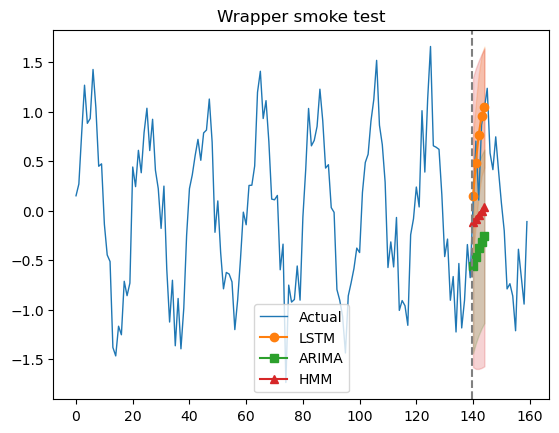

In [10]:
plt.plot(np.arange(len(y)), y, label="Actual", lw=1)
future_idx = np.arange(len(y_train), len(y_train) + 5)

lstm_pdf = lstm_res["forecast_pdf"]
arima_pdf = arima_res["forecast_pdf"]
hmm_pdf = hmm_res["forecast_pdf"]

lstm_mean, lstm_std = _mixture_mean_std(
    lstm_pdf["means"], lstm_pdf["sds"], lstm_pdf["weights"]
)
arima_mean, arima_std = _mixture_mean_std(
    arima_pdf["means"], arima_pdf["sds"], arima_pdf["weights"]
)
hmm_mean, hmm_std = _mixture_mean_std(
    hmm_pdf["means"], hmm_pdf["sds"], hmm_pdf["weights"]
)

line = plt.plot(future_idx, lstm_mean, "o-", label="LSTM")[0]
plt.fill_between(
    future_idx,
    lstm_mean - 1.96 * lstm_std,
    lstm_mean + 1.96 * lstm_std,
    color=line.get_color(),
    alpha=0.2,
)

line = plt.plot(future_idx, arima_mean, "s-", label="ARIMA")[0]
plt.fill_between(
    future_idx,
    arima_mean - 1.96 * arima_std,
    arima_mean + 1.96 * arima_std,
    color=line.get_color(),
    alpha=0.2,
)

line = plt.plot(future_idx, hmm_mean, "^-", label="HMM")[0]
plt.fill_between(
    future_idx,
    hmm_mean - 1.96 * hmm_std,
    hmm_mean + 1.96 * hmm_std,
    color=line.get_color(),
    alpha=0.2,
)

plt.axvline(len(y_train) - 0.5, color="grey", ls="--")
plt.legend()
plt.title("Wrapper smoke test")
plt.show()